In [1]:
import sys ###dppolicyagent
sys.path.append('../scripts/')
from puddle_world import *
import itertools 
import collections 

In [2]:
class DpPolicyAgent(MclAgent):  ###dppolicyagent
    def __init__(self, time_interval, particle_pose, envmap, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}, widths=np.array([0.2, 0.2, math.pi/18]).T, \
                 lowerleft=np.array([-4, -4]).T, upperright=np.array([4, 4]).T): #widths以降はDynamicProgrammingから持ってくる
        super().__init__(time_interval, 0.0, 0.0, particle_pose, envmap, particle_num, motion_noise_stds) 
        
        ###座標関連の変数をDynamicProgrammingから持ってくる###
        self.pose_min = np.r_[lowerleft, 0]  
        self.pose_max = np.r_[upperright, math.pi*2]
        self.widths = widths
        self.index_nums = ((self.pose_max - self.pose_min)/self.widths).astype(int)
        
        self.policy_data = self.init_policy()
        
    def init_policy(self):
        tmp = np.zeros(np.r_[self.index_nums,2])
        for line in open("policy.txt", "r"):
            d = line.split()
            tmp[int(d[0]), int(d[1]), int(d[2])] = [float(d[3]), float(d[4])]
            
        return tmp
        
    def policy(self, pose): #姿勢から離散状態のインデックスを作って方策を参照して返すだけ
        index = np.floor((pose - self.pose_min)/self.widths).astype(int)           #姿勢からインデックスに
        
        index[2] = (index[2] + self.index_nums[2]*1000)%self.index_nums[2] #角度の正規化
        for i in [0,1]:                                                                                   #端の処理（内側の座標の方策を使う）
            if index[i] < 0: index[i] = 0
            elif index[i] >= self.index_nums[i]: index[i] = self.index_nums[i] - 1
                
        return self.policy_data[tuple(index)] #ベクトルのままだとインデックスに使えないのでタプルに
        
    def decision(self, observation=None):
        nu, omega = self.policy(self.mcl.ml_pose)
        self.mcl.motion_update(nu, omega, self.time_interval)
        self.mcl.observation_update(observation)
        
        return nu, omega

<IPython.core.display.Javascript object>


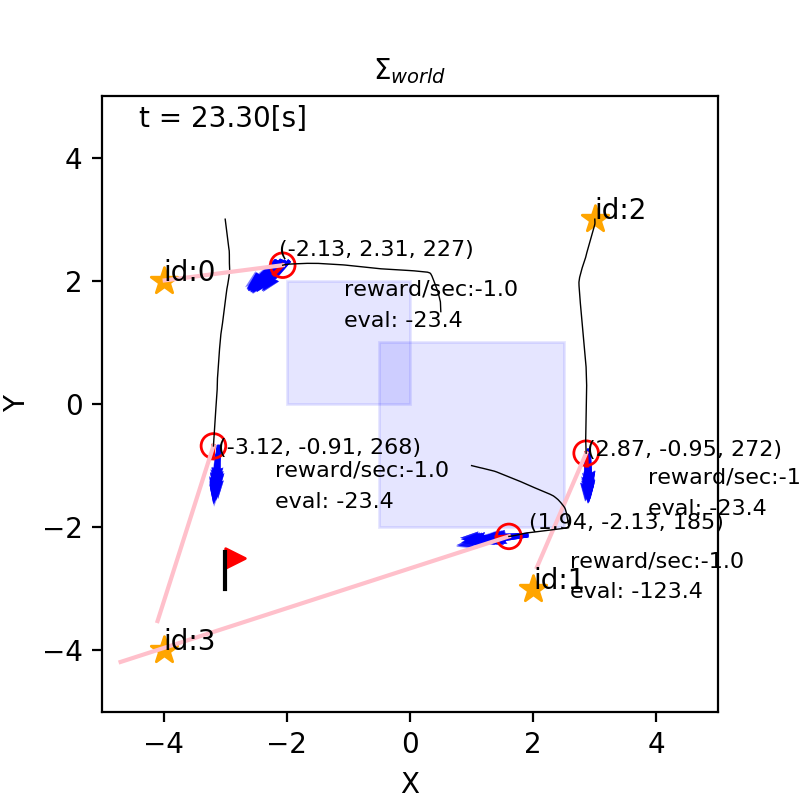

In [3]:
if __name__ == '__main__': 
    time_interval = 0.1
    world = PuddleWorld(400, time_interval)  #長めにアニメーション時間をとる

    m = Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    m.append_landmark(Landmark(-4,-4)) #追加（ゴール方向にランドマークがないので）
    world.append(m)
    
    ###ゴールの追加###
    goal = Goal(-3,-3)
    world.append(goal)
    
    ###水たまりの追加###
    world.append(Puddle((-2, 0), (0, 2), 0.1)) 
    world.append(Puddle((-0.5, -2), (2.5, 1), 0.1))

    ### いくつかの初期位置を定義 ###   ###dppolicyagentrun
    init_poses = []
    for p in [[-3, 3, 0], [0.5, 1.5, 0], [3, 3, 0], [1, -1, 0]]:
        init_pose = np.array(p).T
    
        dpa = DpPolicyAgent(time_interval, init_pose, m)  
        r = PuddleRobot(time_interval, init_pose, sensor=Camera(m, distance_bias_rate_stddev=0, direction_bias_stddev=0),
              agent=dpa, color="red", bias_rate_stds=(0,0))

        world.append(r)
    
    world.draw()
    #r.one_step(0.1) #デバッグ時